In [ ]:
%pylab inline
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

Populating the interactive namespace from numpy and matplotlib


## Afternoon session 2:
### Optimization and Neural Networks

Read the following paper: [An overview of gradient descent optimization
algorithms](https://arxiv.org/pdf/1609.04747.pdf).  
(At least read about stochastic, full-batch and mini-batch gradient descent, SGD, Momentum and Adam.)

Then try to implement the following:
1. Implement Momentum Accelerated gradient-descent for your backprop from scratch example.
    - If you have not implemented your own version this morning, try to finish this or use the provided example code.
    - The provided code also includes a bias term. 
    - All you have to implement are the updates for the bias terms.
    - Compare your results from the 1-hidden layer network with bias, with (momentum=0.9) and without momentum.
    - Does this improve your results?

### Backprop from Scratch with Momentum

In [ ]:
def make_train_test(batch_size, batch_num, test_size, noise=0.05):
    """
    Makes a two-moon train-test dataset with fixed batch size, number and noise level
    """
    X_train, y_train = make_moons(n_samples=batch_size*batch_num, noise=noise)
    y_train = y_train.reshape(batch_num, batch_size, 1)
    X_train = X_train.reshape(batch_num, batch_size, 2)


    X_test, y_test = make_moons(noise=0.1)
    y_test = y_test.reshape(test_size, 1)
    return X_train, y_train, X_test, y_test

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

Step 1: fill in the following values according to the morning session:

In [ ]:
set_seed(42)

epochs = 1000 #Number of loops through whole dataset

batch_size = 1000 #Size of a single batch
batch_num = 1 #Use full batch training
test_size = 100 #Examples in test set

lr = 1.
D, H, M = 2, 3, 1 #Define input size (2), Size of Hidden Layer (4), Output size (1)
momentum = 0.9 #Set to 0.9 to try momentum

Step 2: create a two moon dataset with the parameters defined above and convert them to torch tensors

In [ ]:
#Use Sklearn to create two-moons + noise
X_train, y_train, X_test, y_test = make_train_test(batch_size, batch_num, test_size, noise=0.2)

#Define Train Set in Pytorch
X = torch.from_numpy(X_train).float()[0] #Convert to torch tensor, single batch
y = torch.from_numpy(y_train).float()[0] #Convert to torch tensor, single batch

#Define Test Set in Pytorch
X_test = torch.from_numpy(X_test).float() #Convert to torch tensor, already single batch
y_test = torch.from_numpy(y_test).float() #Convert to torch tensor, already single batch

Step 3: define activation function and neural network parameters

In [ ]:
#Define Activation Functions and Derivatives
sigmoid = lambda x: 1./(1+torch.exp(-x)) #Sigmoid Activation Function
dSigmoid = lambda x: x*(1-x) #Derivative of Sigmoid Activation Function

#Define Neural Network Parameters
W1, W2 = torch.randn((D, H)), torch.randn((H, M)) #Define the weight matrices
b1, b2 = torch.zeros((H)), torch.zeros((M)) #Define the bias matrices

Step 4: define and initialise momentum parameters

In [ ]:
#Define the momentum parameters
if momentum is not None:
    vt_1_W1 = 0.
    vt_1_W2 = 0.
    vt_1_b1 = 0.
    vt_1_b2 = 0.

Step 5: create the training loop and print the loss and accuracy

In [ ]:
#Enter training loop
for i in range(epochs):
    N = X.size(0) #Number of input examples
    #Forward Pass Layer 1
    z1 = torch.matmul(X, W1)+b1 #Affine Layer Transformation z1 = W1*X+b1
    a1 = sigmoid(z1) #Apply non-linear activation function a1 = sigmoid(z1)
    
    #Forward Pass Layer 2
    z2 =  torch.matmul(a1, W2)+b2 #Affine Layer Transformation z2 = W2*a1+b2
    a2 = sigmoid(z2) #Apply non-linear activation function a2 = sigmoid(z2)

    #Backward Pass Layer 2
    dL_da2 = (a2-y) #Compute Error on Output
    da2_dz2 = dSigmoid(a2) #Compute derivative of activation function (Sigmoid)
    
    dL_dW2 = torch.matmul(torch.transpose(a1, 0, 1), dL_da2*da2_dz2) #Compute gradient w.r.t. weights in layer 2       
    dL_db2 = (dL_da2*da2_dz2).sum(0) #Compute gradient w.r.t. bias in layer 2, sums over all N examples
    
    #Backward Pass Layer 1
    dL_da1 = torch.matmul(dL_da2, torch.transpose(W2, 0, 1)) #Compute Error on Output of Layer 1
    da1_dz1 = dSigmoid(a1) #Compute derivative of activation function (Sigmoid)
    
    dL_dW1 = torch.matmul(torch.transpose(X, 0, 1), dL_da1*da1_dz1) #Compute gradient w.r.t. weights in layer 2
    dL_db1 = (dL_da1*da1_dz1).sum(0)  #Compute gradient w.r.t. bias in layer 1, sums over all N examples

    #Sensitivity w.r.t. Input
    dL_dX = torch.matmul(dL_da1, torch.transpose(W1, 0, 1)) #Compute gradient w.r.t. input X
    
    #Gradient Descent with Momentum
    if momentum is not None:
        vt_W1 = momentum*vt_1_W1+lr/N*dL_dW1 #Momentum step for layer 1 weights
        W1 = W1 - vt_W1 #Take a step in momentum weighted direction on layer 1 weights
        vt_1_W1 = vt_W1
        
        vt_W2 = momentum*vt_1_W2+lr/N*dL_dW2
        W2 = W2 - vt_W2  #Take a step in momentum weighted direction on layer 2 weights
        vt_1_W2 = vt_W2       

        vt_b1 = momentum*vt_1_b1+lr/N*dL_db1
        b1 = b1 - vt_b1 #Take a step in momentum weighted direction on layer 1 bias
        vt_1_b1 = vt_b1     
        
        vt_b2 = momentum*vt_1_b2+lr/N*dL_db2
        b2 = b2 - vt_b2  #Take a step in momentum weighted direction on layer 2 bias
        vt_1_b2 = vt_b2      
        
    else: #Gradient Descent
        W1 = W1 - lr/N*dL_dW1 #Take a step in gradient direction on layer 1 weights
        b1 = b1 - lr/N*dL_db1 #Take a step in gradient direction on layer 1 bias

        W2 = W2 - lr/N*dL_dW2 #Take a step in gradient direction on layer 2 weights
        b2 = b2 - lr/N*dL_db2 #Take a step in gradient direction on layer 2 bias
    
    train_loss = -1./N*(y*torch.log(a2)+(1-y)*torch.log(1-a2)).sum(0) #Compute Average Binary-Crossentropy Loss
    if i % 100 == 0:
        print("Training Loss in epoch "+str(i)+": %1.2f" % train_loss.item())
        print("Training accuracy in epoch "+str(i)+": %1.2f" % accuracy_score(y, np.where(a2[:, 0].numpy()>0.5, 1, 0)),"\n")

Training Loss in epoch 0: 0.86
Training accuracy in epoch 0: 0.50 

Training Loss in epoch 100: 0.31
Training accuracy in epoch 100: 0.87 

Training Loss in epoch 200: 0.29
Training accuracy in epoch 200: 0.87 

Training Loss in epoch 300: 0.29
Training accuracy in epoch 300: 0.87 

Training Loss in epoch 400: 0.29
Training accuracy in epoch 400: 0.87 

Training Loss in epoch 500: 0.28
Training accuracy in epoch 500: 0.87 

Training Loss in epoch 600: 0.27
Training accuracy in epoch 600: 0.89 

Training Loss in epoch 700: 0.21
Training accuracy in epoch 700: 0.95 

Training Loss in epoch 800: 0.14
Training accuracy in epoch 800: 0.97 

Training Loss in epoch 900: 0.12
Training accuracy in epoch 900: 0.97 



Perform a forward pass of the test dataset and print the train loss, accuracy for both test and training

In [ ]:
#Do Forward Pass of Test Dataset
#Forward Pass Layer 1
z1_t = torch.matmul(X_test, W1) + b1 #Affine Layer Transformation z1 = W1*X+b1
a1 = sigmoid(z1_t) #Apply non-linear activation function a1 = sigmoid(z1)

#Forward Pass Layer 2
z2 =  torch.matmul(a1, W2) + b2 #Affine Layer Transformation z2 = W2*a1+b2
a_test = sigmoid(z2) #Apply non-linear activation function a2 = sigmoid(z2)
test_loss = -(y_test*torch.log(a_test)+(1-y_test)*torch.log(1-a_test)).mean(0) #Compute Binary-Crossentropy Loss

print("End of Training -> Testing Phase: ")
print("Train Loss: %1.2f" % train_loss.item(), ", Test Loss: %1.2f" % test_loss.item())
print("Training accuracy in epoch "+str(i)+": %1.2f" % accuracy_score(y, np.where(a2[:, 0].numpy()>0.5, 1, 0)))
print("Test accuracy in epoch "+str(i)+": %1.2f" % accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))      

End of Training -> Testing Phase: 
Train Loss: 0.11 , Test Loss: 0.06
Training accuracy in epoch 999: 0.97
Test accuracy in epoch 999: 1.00


Plot results (use the same plotting code from the morning)



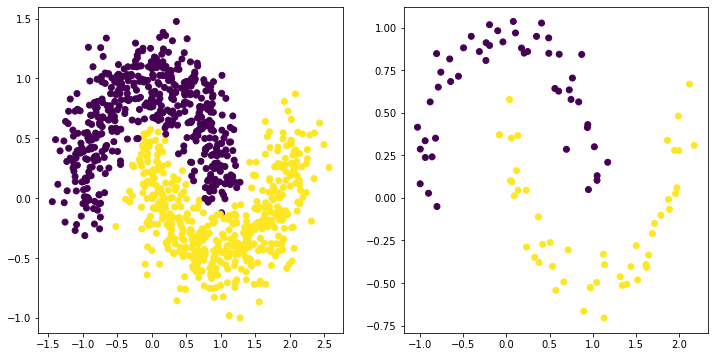

In [ ]:
# plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X[:, 0], X[:, 1], c=np.where(a2[:, 0].numpy()>0.5, 1, 0))
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=np.where(a_test[:, 0].numpy()>0.5, 1, 0))